In [242]:
import pandas as pd
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors, linear_model
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.svm import SVC
import pydot

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions
%matplotlib inline

from IPython.display import display, HTML
pd.options.display.max_rows = None
pd.options.display.max_columns = None

# Question I: Revisiting HW4 Bank Classication with New Tools (for dataset A) 

# I. Loading the dataset and performing data preprocessing

> Load a simple dataset and perform some basic data preprocessing to fill out ”unknowns”,
outliers or other invalid data. Explain what preprocessing was performed and why. Also,
change categorical data into numerical features using pandas.get dummies [5].

In [243]:
bank_addidtional_full = "bank-additional.csv"

data = pd.read_csv(bank_addidtional_full, sep = ';', na_values=["unknown"])
df = pd.DataFrame(data)
df.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,487,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,346,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,227,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,NaN,NaN,telephone,jun,fri,17,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,58,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no
5,32,services,single,university.degree,no,no,no,cellular,sep,thu,128,3,999,2,failure,-1.1,94.199,-37.5,0.884,4963.6,no
6,32,admin.,single,university.degree,no,yes,no,cellular,sep,mon,290,4,999,0,nonexistent,-1.1,94.199,-37.5,0.879,4963.6,no
7,41,entrepreneur,married,university.degree,NaN,yes,no,cellular,nov,mon,44,2,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no
8,31,services,divorced,professional.course,no,no,no,cellular,nov,tue,68,1,999,1,failure,-0.1,93.200,-42.0,4.153,5195.8,no
9,35,blue-collar,married,basic.9y,NaN,no,no,telephone,may,thu,170,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no


### We first check for missing values in the dataset. There was 1230 entries as unknown in the catogerical features that were replaced with NaN.

In [244]:
print(df.isnull().sum().sum())
print(df.shape)
df.info()

1230
(4119, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
age               4119 non-null int64
job               4080 non-null object
marital           4108 non-null object
education         3952 non-null object
default           3316 non-null object
housing           4014 non-null object
loan              4014 non-null object
contact           4119 non-null object
month             4119 non-null object
day_of_week       4119 non-null object
duration          4119 non-null int64
campaign          4119 non-null int64
pdays             4119 non-null int64
previous          4119 non-null int64
poutcome          4119 non-null object
emp.var.rate      4119 non-null float64
cons.price.idx    4119 non-null float64
cons.conf.idx     4119 non-null float64
euribor3m         4119 non-null float64
nr.employed       4119 non-null float64
y                 4119 non-null object
dtypes: float64(5), int64(5), object(11)
memory usage: 675

# NaN values were replaced by the mode of the column

In [245]:
df = df.fillna(df.mode().iloc[0])

In [246]:
df.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,487,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,346,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,227,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,yes,no,telephone,jun,fri,17,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,58,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no
5,32,services,single,university.degree,no,no,no,cellular,sep,thu,128,3,999,2,failure,-1.1,94.199,-37.5,0.884,4963.6,no
6,32,admin.,single,university.degree,no,yes,no,cellular,sep,mon,290,4,999,0,nonexistent,-1.1,94.199,-37.5,0.879,4963.6,no
7,41,entrepreneur,married,university.degree,no,yes,no,cellular,nov,mon,44,2,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no
8,31,services,divorced,professional.course,no,no,no,cellular,nov,tue,68,1,999,1,failure,-0.1,93.200,-42.0,4.153,5195.8,no
9,35,blue-collar,married,basic.9y,no,no,no,telephone,may,thu,170,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no


### Then we convert all the catogrical columns to numerical columns. Also, dropping the duration column since is a predictive variable according to UCI website and should be dropped if the purpose is to build a realistic model

In [247]:
print(df.shape)
df._get_numeric_data().head()
df['y'] = df['y'].map({'yes': 1, 'no': 0})
df.drop(['duration'], axis=1, inplace=True)
df = pd.get_dummies(df,drop_first=True)
display(df.head(5))

(4119, 21)


,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,default_yes,housing_yes,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,30,2,999,0,-1.8,92.893,-46.2,1.313,5099.1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,39,4,999,0,1.1,93.994,-36.4,4.855,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,25,1,999,0,1.4,94.465,-41.8,4.962,5228.1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0
3,38,3,999,0,1.4,94.465,-41.8,4.959,5228.1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,47,1,999,0,-0.1,93.200,-42.0,4.191,5195.8,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0


In [248]:
df.shape

(4119, 47)

In [249]:
cols = list(df.columns.values) #Make a list of all of the columns in the df
cols.pop(cols.index('y')) #Remove y from list
df = df[cols + ['y']] #Create new dataframe with columns in the order you want
display(df.head(5))

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,default_yes,housing_yes,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,y
0,30,2,999,0,-1.8,92.893,-46.2,1.313,5099.1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,39,4,999,0,1.1,93.994,-36.4,4.855,5191.0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,25,1,999,0,1.4,94.465,-41.8,4.962,5228.1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0
3,38,3,999,0,1.4,94.465,-41.8,4.959,5228.1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,47,1,999,0,-0.1,93.200,-42.0,4.191,5195.8,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0


### According to UCI dataset description, the pdays columns (which represents the number of days passed by after the client was last contacted from a previous campaign) has some 999 values which means that client was not previously contacted. We replaced these 999 values with 0 since samples with 999 entries would be considered as an outliers when it comes to data cleaning. There was found to be 3,959 samples in the pdays column that had to be replaced with 0 instead of 999



999    3959
3        52
6        42
4        14
7        10
10        8
12        5
5         4
2         4
9         3
1         3
13        2
18        2
16        2
15        2
0         2
14        1
19        1
21        1
17        1
11        1
Name: pdays, dtype: int64

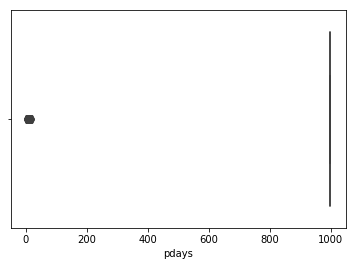

In [250]:
sns.boxplot(x=df['pdays'])
df['pdays'].value_counts()
# data['pdays'].isna().sum().sum()

count    160.000000
mean       5.862500
std        3.911743
min        0.000000
25%        3.000000
50%        6.000000
75%        6.000000
max       21.000000
Name: pdays, dtype: float64

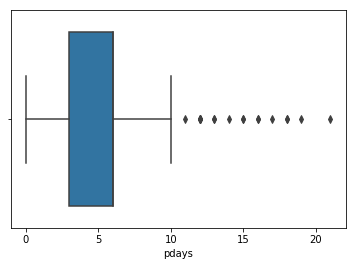

In [251]:
df.pdays = df.pdays.replace({999: np.nan })
display(df.pdays.describe())
sns.boxplot(x=df['pdays'])

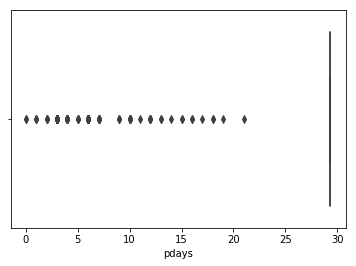

In [252]:
df.pdays = df.pdays.fillna(df.pdays.mean() + df.pdays.std()*6)
sns.boxplot(x=df['pdays'])

### Now detecting the outliers and keeping samples that are only within 3 standard deviations

In [253]:
# df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
# keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.

In [254]:
print(df.shape)
df.head()

(4119, 47)


,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,default_yes,housing_yes,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,y
0,30,2,29.332955,0,-1.8,92.893,-46.2,1.313,5099.1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,39,4,29.332955,0,1.1,93.994,-36.4,4.855,5191.0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,25,1,29.332955,0,1.4,94.465,-41.8,4.962,5228.1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0
3,38,3,29.332955,0,1.4,94.465,-41.8,4.959,5228.1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,47,1,29.332955,0,-0.1,93.200,-42.0,4.191,5195.8,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0


In [255]:
df['y'].value_counts()

0    3668
1     451
Name: y, dtype: int64

In [256]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 47 columns):
age                              4119 non-null int64
campaign                         4119 non-null int64
pdays                            4119 non-null float64
previous                         4119 non-null int64
emp.var.rate                     4119 non-null float64
cons.price.idx                   4119 non-null float64
cons.conf.idx                    4119 non-null float64
euribor3m                        4119 non-null float64
nr.employed                      4119 non-null float64
job_blue-collar                  4119 non-null uint8
job_entrepreneur                 4119 non-null uint8
job_housemaid                    4119 non-null uint8
job_management                   4119 non-null uint8
job_retired                      4119 non-null uint8
job_self-employed                4119 non-null uint8
job_services                     4119 non-null uint8
job_student                      

In [257]:
df.head(10)

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,default_yes,housing_yes,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,y
0,30,2,29.332955,0,-1.8,92.893,-46.2,1.313,5099.1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,39,4,29.332955,0,1.1,93.994,-36.4,4.855,5191.0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,25,1,29.332955,0,1.4,94.465,-41.8,4.962,5228.1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0
3,38,3,29.332955,0,1.4,94.465,-41.8,4.959,5228.1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,47,1,29.332955,0,-0.1,93.200,-42.0,4.191,5195.8,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
5,32,3,29.332955,2,-1.1,94.199,-37.5,0.884,4963.6,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
6,32,4,29.332955,0,-1.1,94.199,-37.5,0.879,4963.6,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0
7,41,2,29.332955,0,-0.1,93.200,-42.0,4.191,5195.8,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
8,31,1,29.332955,1,-0.1,93.200,-42.0,4.153,5195.8,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
9,35,1,29.332955,0,1.1,93.994,-36.4,4.855,5191.0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0


# II. Dividing data into training and testing

Splitting the data into train and test data. The test data size chosen to be 30%.

In [258]:
X = df.drop('y',axis=1)
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30,random_state=101)

In [259]:
X_test.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,default_yes,housing_yes,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
3489,31,3,29.332955,1,-1.8,93.075,-47.1,1.466,5099.1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1380,45,2,29.332955,0,1.4,94.465,-41.8,4.961,5228.1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
1183,34,2,6.000000,1,-0.1,93.200,-42.0,4.120,5195.8,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1
1320,58,3,29.332955,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
74,31,1,29.332955,0,1.4,93.444,-36.1,4.966,5228.1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0


# III. Applying classification: 

# a) Decision Tree

## First, the classifier was instantiated with the default parameters and then was tuned later for comparison

In [260]:
dtree = DecisionTreeClassifier(random_state=101)
dtree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=101,
            splitter='best')

## Predicting and evaluating the model

In [261]:
predictions = dtree.predict(X_test)
print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

[[991 111]
 [ 92  42]]


              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1102
           1       0.27      0.31      0.29       134

   micro avg       0.84      0.84      0.84      1236
   macro avg       0.59      0.61      0.60      1236
weighted avg       0.85      0.84      0.84      1236



## Area under curve (AUC) is plotted below to check for overfitting cases with depth of the tree

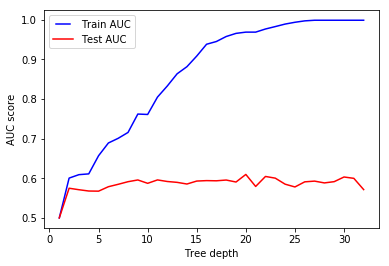

In [262]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []

for max_depth in max_depths:
   dt = DecisionTreeClassifier(max_depth=max_depth)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()
#Source: https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

Based on the graph above, we see that when we have a high tree depth we get an overfitting case where the model can predicts the train data perfectly (high area under curve), however, the models fails to generalize and predict new data (test data)

In [263]:
clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=3, min_samples_leaf=5)

In [264]:
dt_clf = clf_gini.fit(X_train, y_train)

In [265]:
y_pred = dt_clf.predict(X_test)

In [266]:
print("Accuracy is ", accuracy_score(y_test,y_pred)*100)
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

Accuracy is  89.56310679611651
[[1086   16]
 [ 113   21]]


              precision    recall  f1-score   support

           0       0.91      0.99      0.94      1102
           1       0.57      0.16      0.25       134

   micro avg       0.90      0.90      0.90      1236
   macro avg       0.74      0.57      0.59      1236
weighted avg       0.87      0.90      0.87      1236



In [267]:
# min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
# train_results = []
# test_results = []
# for min_samples_split in min_samples_splits:
#    dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
#    dt.fit(X_train, y_train)
#    train_pred = dt.predict(X_train)
#    false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train, train_pred)
#    roc_auc = auc(false_positive_rate, true_positive_rate)
#    train_results.append(roc_auc)
#    y_pred = dt.predict(X_test)
#    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#    roc_auc = auc(false_positive_rate, true_positive_rate)
#    test_results.append(roc_auc)
# from matplotlib.legend_handler import HandlerLine2D
# line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
# line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
# plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
# plt.ylabel('AUC score')
# plt.xlabel('min samples split')
# plt.show()

In [268]:
# min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
# train_results = []
# test_results = []
# for min_samples_leaf in min_samples_leafs:
#    dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
#    dt.fit(X_train, y_train)
#    train_pred = dt.predict(X_train)
#    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
#    roc_auc = auc(false_positive_rate, true_positive_rate)
#    train_results.append(roc_auc)
#    y_pred = dt.predict(X_test)
#    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#    roc_auc = auc(false_positive_rate, true_positive_rate)
#    test_results.append(roc_auc)
# from matplotlib.legend_handler import HandlerLine2D
# line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train AUC")
# line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test AUC")
# plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
# plt.ylabel('AUC score')
# plt.xlabel('min samples leaf')
# plt.show()

## Tree Visualization using the the built-in visualization from Scikit learn. This requires to install the pydot library and Graphviz.

In [269]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydot 

features = list(X_train.columns)

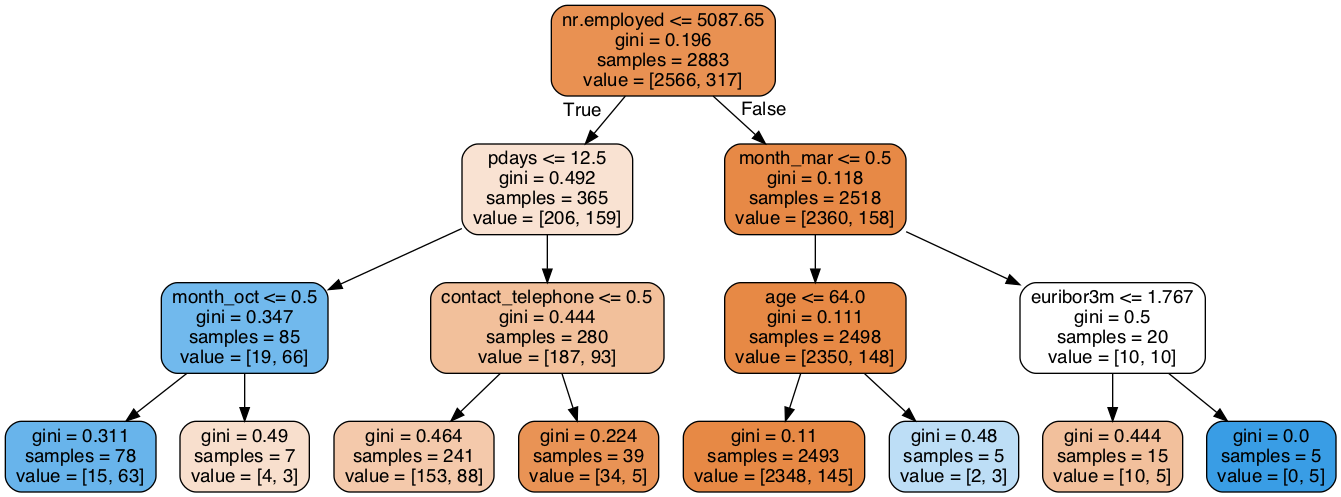

In [270]:
dot_data = StringIO()  
export_graphviz(clf_gini, out_file=dot_data,feature_names=features,filled=True,rounded=True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png()) 

# b) Random Forests (RF)

We will first fit the model with default parameters and evaluate the performance, then we will tune the parameters and compare the performance. 

In [271]:
rfc = RandomForestClassifier(random_state=101)
rfc_clf = rfc.fit(X_train, y_train)

/Users/ammarahmed/Desktop/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [272]:
rfc_pred = rfc_clf.predict(X_test)

In [273]:
print("Accuracy is ", accuracy_score(y_test,rfc_pred)*100)
print(confusion_matrix(y_test,rfc_pred))
print('\n')
print(classification_report(y_test,rfc_pred))

Accuracy is  89.15857605177993
[[1074   28]
 [ 106   28]]


              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1102
           1       0.50      0.21      0.29       134

   micro avg       0.89      0.89      0.89      1236
   macro avg       0.71      0.59      0.62      1236
weighted avg       0.87      0.89      0.87      1236



Similar to DT classifier, we will use the area under curve AUC to evaluate the model. 

In [274]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5710986808245524

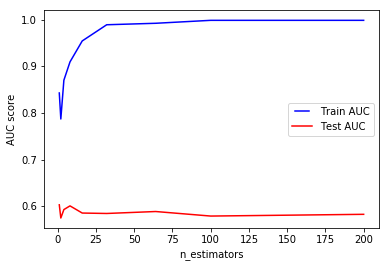

In [275]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []

for estimator in n_estimators:
   rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1, random_state=101)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

    
line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()
# Source: https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

The n_estimators in the random forests classifier represents the numsber of trees used in the classifier. Based on the AUC graph above, we see that the highest AUC score for the test data will be around 16 n_estimators. Increasing the n_estimators decreases the test perfomance. 

/Users/ammarahmed/Desktop/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ammarahmed/Desktop/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ammarahmed/Desktop/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ammarahmed/Desktop/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureW

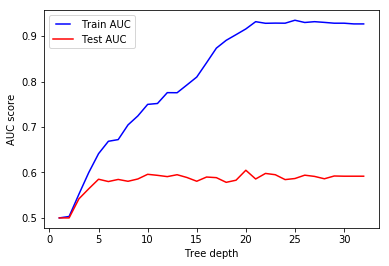

In [276]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []

for max_depth in max_depths:
   rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1, random_state=101)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()
#Source: https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

We see that the higher the tree depth, we get an overfitting case. So a tree depth of 3 wil be chosen

In [277]:
RFC = RandomForestClassifier(n_estimators=16,random_state=101, max_depth=3)
RFC_clf = RFC.fit(X_train, y_train)
RFC_pred = RFC.predict(X_test)


print("Results from the default parameters:")
print("Accuracy is ", accuracy_score(y_test,rfc_pred)*100)
print(confusion_matrix(y_test,rfc_pred))
print(classification_report(y_test,rfc_pred))
print('\n')
print("Results from the tunned parameters:")
print("Accuracy is ", accuracy_score(y_test,RFC_pred)*100)
print(confusion_matrix(y_test,RFC_pred))
print(classification_report(y_test,RFC_pred))

Results from the default parameters:
Accuracy is  89.15857605177993
[[1074   28]
 [ 106   28]]
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1102
           1       0.50      0.21      0.29       134

   micro avg       0.89      0.89      0.89      1236
   macro avg       0.71      0.59      0.62      1236
weighted avg       0.87      0.89      0.87      1236



Results from the tunned parameters:
Accuracy is  89.96763754045307
[[1092   10]
 [ 114   20]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1102
           1       0.67      0.15      0.24       134

   micro avg       0.90      0.90      0.90      1236
   macro avg       0.79      0.57      0.60      1236
weighted avg       0.88      0.90      0.87      1236



# C) Neural Networks (NN)

Data should be normalized before training the neural network model. This is because the NN model might not converge before the max number of iterations allowed. Also, the multi-layer perception is sensitive to scaling the features. (source: https://www.kdnuggets.com/2016/10/beginners-guide-neural-networks-python-scikit-learn.html/2)



In [278]:
scaler = StandardScaler()
scaler.fit(df.drop('y',axis=1))
scaled_features = scaler.transform(df.drop('y',axis=1))

df_feat = pd.DataFrame(scaled_features,columns=df.columns[:-1])

X_nn = df_feat.loc[:,]
y_nn = df['y']
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_nn,y_nn, test_size=0.30,random_state=101)


/Users/ammarahmed/Desktop/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/ammarahmed/Desktop/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [279]:
# Testing with 2 layers with number of neurons:(36,36)
mlp = MLPClassifier(max_iter=1000,random_state=101, hidden_layer_sizes=(36,36))

In [280]:
nn_clf = mlp.fit(X_train_nn,y_train_nn)

predicting and evaluating

In [281]:
predictions = nn_clf.predict(X_test_nn)

In [282]:
print("Accuracy is ", accuracy_score(y_test,predictions)*100)
print(confusion_matrix(y_test,predictions))
print("\n")
print(classification_report(y_test,predictions))

Accuracy is  84.8705501618123
[[1010   92]
 [  95   39]]


              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1102
           1       0.30      0.29      0.29       134

   micro avg       0.85      0.85      0.85      1236
   macro avg       0.61      0.60      0.60      1236
weighted avg       0.85      0.85      0.85      1236



Tunning the NN parameters using the GridSearchCV method.

In [303]:
parameter_space = {
    'max_iter': [1300],
    'hidden_layer_sizes': [(32,32), (20,20), (47,47)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam','lbfgs'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant'],
    'random_state': [101]
}

In [304]:
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)

In [305]:
clf.fit(X_train_nn, y_train_nn)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(36, 36), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=101, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_iter': [1300], 'hidden_layer_sizes': [(32, 32), (20, 20), (47, 47)], 'activation': ['tanh', 'relu'], 'solver': ['sgd', 'adam', 'lbfgs'], 'alpha': [0.0001, 0.05], 'learning_rate': ['constant'], 'random_state': [101]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [306]:
# Best parameter set
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (32, 32), 'learning_rate': 'constant', 'max_iter': 1300, 'random_state': 101, 'solver': 'sgd'}


In [307]:
mlp_nn = MLPClassifier(activation = 'tanh',alpha = 0.0001, learning_rate= 'constant', solver = 'sgd', random_state=101, hidden_layer_sizes=(32,32), max_iter=1000)

In [308]:
y_true, y_pred = y_test_nn , clf.predict(X_test_nn)

print("Results from the default parameters:")
print("Accuracy is ", accuracy_score(y_test,predictions)*100)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print("\n")
print("Results from the tunned parameters:")
print("Accuracy is ", accuracy_score(y_true,y_pred)*100)
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true, y_pred))


Results from the default parameters:
Accuracy is  84.8705501618123
[[1010   92]
 [  95   39]]
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1102
           1       0.30      0.29      0.29       134

   micro avg       0.85      0.85      0.85      1236
   macro avg       0.61      0.60      0.60      1236
weighted avg       0.85      0.85      0.85      1236



Results from the tunned parameters:
Accuracy is  89.40129449838187
[[1083   19]
 [ 112   22]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1102
           1       0.54      0.16      0.25       134

   micro avg       0.89      0.89      0.89      1236
   macro avg       0.72      0.57      0.60      1236
weighted avg       0.87      0.89      0.87      1236



# IV. Creating plots of the models on the test data

# Plotting best two features for the DT

 Listing the the important features for the decision tree

In [309]:
X_test_df =pd.DataFrame(X_test, columns=df.columns[:-1]) 
y_test_df = pd.DataFrame(y_test, columns = ['y'])
X_test_df.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,default_yes,housing_yes,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
3489,31,3,29.332955,1,-1.8,93.075,-47.1,1.466,5099.1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1380,45,2,29.332955,0,1.4,94.465,-41.8,4.961,5228.1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
1183,34,2,6.000000,1,-0.1,93.200,-42.0,4.120,5195.8,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1
1320,58,3,29.332955,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
74,31,1,29.332955,0,1.4,93.444,-36.1,4.966,5228.1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0


In [310]:
list(zip(X_test_df.columns, dt_clf.feature_importances_))

[('age', 0.7591189553571596), ('campaign', 0.24088104464284052)]

Accuracy: 0.90 (+/- 0.00) [Decision Tree]
Accuracy: 0.90 (+/- 0.00) [Random Forests]


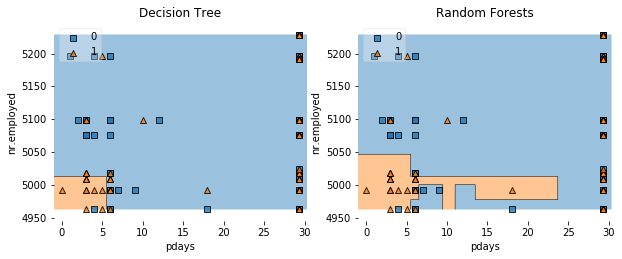

In [311]:
X = X_test_df.iloc[:, ]
X = X[['pdays','nr.employed']]
y= y_test_df['y']



label = ['Decision Tree', 'Random Forests']
clf_list = [clf_gini, RFC]

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

X = X.values
y = y.values

for clf, label, grd in zip(clf_list, label, grid):        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(label)
    plt.xlabel('pdays')
    plt.ylabel('nr.employed')

plt.show()

Accuracy: 0.89 (+/- 0.01) [Decision Tree]
Accuracy: 0.89 (+/- 0.01) [Random Forests]


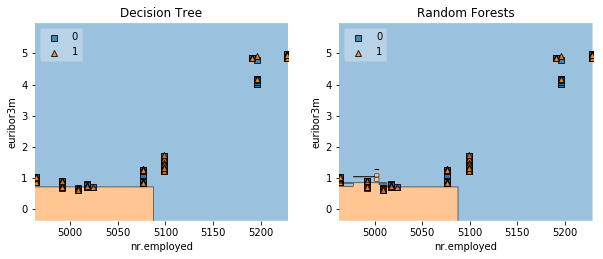

In [312]:
X = X_test_df.iloc[:, ]
X = X[['nr.employed','euribor3m']]
y= y_test_df['y']



label = ['Decision Tree', 'Random Forests']
clf_list = [clf_gini, RFC]

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

X = X.values
y = y.values

for clf, label, grd in zip(clf_list, label, grid):        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(label)
    plt.xlabel('nr.employed')
    plt.ylabel('euribor3m')

plt.show()

# Plotting best two features for the Random Forest

Listing important features for Random Forest

In [313]:
list(zip(X_test_df.columns, RFC_clf.feature_importances_))

[('age', 0.5182159658162222), ('campaign', 0.4817840341837777)]

Accuracy: 0.89 (+/- 0.00) [Decision Tree]
Accuracy: 0.89 (+/- 0.01) [Random Forests]


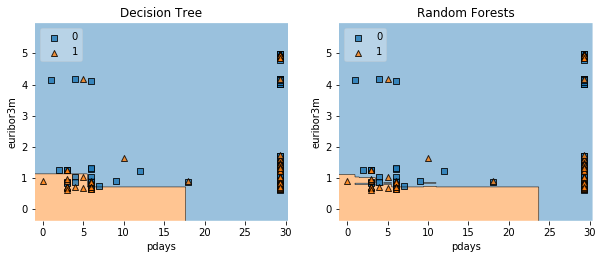

In [314]:
X = X_test_df.iloc[:, ]
X = X[['pdays','euribor3m']]
y= y_test_df['y']


label = ['Decision Tree', 'Random Forests']
clf_list = [clf_gini, RFC]

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

X = X.values
y = y.values


for clf, label, grd in zip(clf_list, label, grid):        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(label)
    plt.xlabel('pdays')
    plt.ylabel('euribor3m')

plt.show()

Accuracy: 0.89 (+/- 0.01) [Decision Tree]
Accuracy: 0.89 (+/- 0.01) [Random Forests]


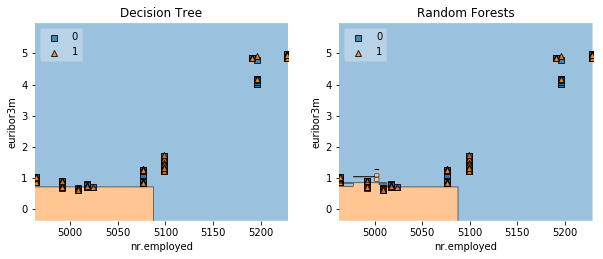

In [315]:
X = X_test_df.iloc[:, ]
X = X[['nr.employed','euribor3m']]
y= y_test_df['y']


label = ['Decision Tree', 'Random Forests']
clf_list = [clf_gini, RFC]

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

X = X.values
y = y.values


for clf, label, grd in zip(clf_list, label, grid):        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(label)
    plt.xlabel('nr.employed')
    plt.ylabel('euribor3m')

plt.show()

# Plotting best two features for the Neural Network

Listing important features for Random Forest

In [316]:
X_testnn_df =pd.DataFrame(X_test_nn, columns=df.columns[:-1]) 
y_testnn_df = pd.DataFrame(y_test_nn, columns = ['y'])
X_testnn_df.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,default_yes,housing_yes,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
3489,-0.883778,0.180203,0.198207,1.494607,-1.206054,-0.871264,-1.436846,-1.243440,-0.914779,-0.522744,-0.193055,-0.165645,-0.292191,-0.204923,-0.200378,-0.324769,-0.142521,2.227314,-0.166417,0.796570,-0.623489,-0.242068,-0.402391,-0.536649,-0.015583,2.588255,-0.729634,-0.015583,-1.113465,-0.438783,-0.743752,-0.427319,-0.073279,-0.456757,-0.384283,-0.108585,-0.709039,-0.348463,-0.130526,-0.12563,1.953854,-0.513697,-0.506516,-0.489050,-2.431270,-0.188958
1380,0.473849,-0.209228,0.198207,-0.351356,0.841389,1.528273,-0.283172,0.772851,0.836535,1.912983,-0.193055,-0.165645,-0.292191,-0.204923,-0.200378,-0.324769,-0.142521,-0.448971,-0.166417,0.796570,-0.623489,-0.242068,-0.402391,-0.536649,-0.015583,-0.386361,-0.729634,-0.015583,-1.113465,2.279032,1.344534,-0.427319,-0.073279,-0.456757,2.602249,-0.108585,-0.709039,-0.348463,-0.130526,-0.12563,-0.511809,-0.513697,1.974270,-0.489050,0.411308,-0.188958
1183,-0.592858,-0.209228,-4.874488,1.494607,-0.118350,-0.655478,-0.326707,0.287672,0.398028,-0.522744,-0.193055,-0.165645,3.422421,-0.204923,-0.200378,-0.324769,-0.142521,-0.448971,-0.166417,-1.255382,1.603876,-0.242068,-0.402391,1.863414,-0.015583,-0.386361,-0.729634,-0.015583,0.898097,2.279032,-0.743752,-0.427319,-0.073279,-0.456757,-0.384283,-0.108585,-0.709039,2.869743,-0.130526,-0.12563,-0.511809,-0.513697,-0.506516,2.044782,-2.431270,5.292168
1320,1.734503,0.180203,0.198207,-0.351356,0.649441,0.715193,0.892269,0.712852,0.332862,-0.522744,-0.193055,-0.165645,-0.292191,-0.204923,-0.200378,-0.324769,-0.142521,-0.448971,-0.166417,-1.255382,1.603876,-0.242068,-0.402391,-0.536649,-0.015583,-0.386361,1.370550,-0.015583,-1.113465,-0.438783,1.344534,-0.427319,-0.073279,-0.456757,-0.384283,-0.108585,1.410360,-0.348463,-0.130526,-0.12563,1.953854,-0.513697,-0.506516,-0.489050,0.411308,-0.188958
74,-0.883778,-0.598660,0.198207,-0.351356,0.841389,-0.234264,0.957571,0.775735,0.836535,-0.522744,-0.193055,-0.165645,-0.292191,-0.204923,-0.200378,-0.324769,-0.142521,2.227314,-0.166417,-1.255382,1.603876,-0.242068,-0.402391,1.863414,-0.015583,-0.386361,-0.729634,-0.015583,0.898097,2.279032,-0.743752,2.340174,-0.073279,-0.456757,-0.384283,-0.108585,-0.709039,-0.348463,-0.130526,-0.12563,-0.511809,-0.513697,1.974270,-0.489050,0.411308,-0.188958


Accuracy: 0.89 (+/- 0.01) [Neural Network]


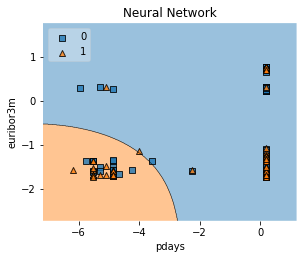

In [317]:
X = X_testnn_df.iloc[:, ]
X = X[['pdays','euribor3m']]
y= y_testnn_df['y']


label = ['Neural Network']
clf_list = [mlp_nn]

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

X = X.values
y = y.values


for clf, label, grd in zip(clf_list, label, grid):        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(label)
    plt.xlabel('pdays')
    plt.ylabel('euribor3m')

    
plt.show()

Accuracy: 0.89 (+/- 0.00) [Neural Network]


/Users/ammarahmed/Desktop/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


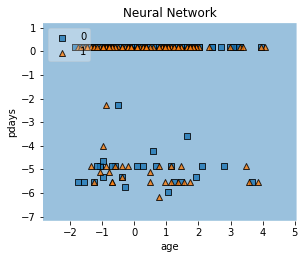

In [318]:
# X = X_testnn_df.iloc[:, ]
# X = X[['age','pdays']]
# y= y_testnn_df['y']


# label = ['Neural Network']
# clf_list = [mlp_nn]

# fig = plt.figure(figsize=(10, 8))
# gs = gridspec.GridSpec(2, 2)
# grid = itertools.product([0,1],repeat=2)

# X = X.values
# y = y.values


# for clf, label, grd in zip(clf_list, label, grid):        
#     scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
#     print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
        
#     clf.fit(X, y)
#     ax = plt.subplot(gs[grd[0], grd[1]])
#     fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
#     plt.title(label)
#     plt.xlabel('age')
#     plt.ylabel('pdays')

    
# plt.show()

Accuracy: 0.89 (+/- 0.01) [Neural Network]


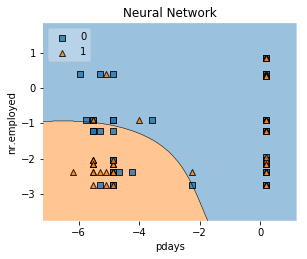

In [321]:
X = X_testnn_df.iloc[:, ]
X = X[['pdays','nr.employed']]
y= y_testnn_df['y']


label = ['Neural Network']
clf_list = [mlp_nn]

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

X = X.values
y = y.values


for clf, label, grd in zip(clf_list, label, grid):        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(label)
    plt.xlabel('pdays')
    plt.ylabel('nr.employed')

    
plt.show()